In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset
from wangdao_deeplearning_train import EarlyStopping, ModelSaver
from wangdao_deeplearning_train import plot_learning_curves,plot_learning_loss_curves,train_regression_model,evaluate_regression_model
import os

In [2]:
# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 加载加利福尼亚房价数据集
housing = fetch_california_housing()
X = housing.data
y = housing.target

# 数据拆分：训练集(60%)、验证集(20%)、测试集(20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)  # 0.25 x 0.8 = 0.2

print(f"训练集大小: {X_train.shape[0]}")
print(f"验证集大小: {X_val.shape[0]}")
print(f"测试集大小: {X_test.shape[0]}")

# 数据标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 自定义数据集类
class HousingDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets).view(-1, 1)
        
    def __len__(self):
        return len(self.features) #返回样本数量
    
    def __getitem__(self, idx): #传入索引，返回对应索引样本的特征和目标
        return self.features[idx], self.targets[idx]

# 创建数据集实例
train_dataset = HousingDataset(X_train_scaled, y_train)
val_dataset = HousingDataset(X_val_scaled, y_val)
test_dataset = HousingDataset(X_test_scaled, y_test)

训练集大小: 13209
验证集大小: 3303
测试集大小: 4128


# 加载数据，构建模型

In [3]:
from torch import optim
# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# 定义Wide & Deep神经网络模型
class WideDeepModel(nn.Module):
    def __init__(self, input_dim):
        super(WideDeepModel, self).__init__()
        # Deep部分使用Sequential
        self.deep_network = nn.Sequential(
            nn.Linear(input_dim, 30),
            nn.ReLU(),
            nn.Linear(30, 30),
            nn.ReLU()
        )
        
        # Wide部分直接使用原始特征
        
        # 输出层，接收deep部分的30维特征和wide部分的input_dim维特征
        self.output = nn.Linear(30 + input_dim, 1)  # 输出层
        
    def forward(self, x): #x的shape是[batch_size, input_dim]
        # Wide部分
        wide_features = x  # 直接使用原始特征
        
        # Deep部分
        deep_features = self.deep_network(x) #deep_features的shape是[batch_size, 30]
        
        # 合并Wide和Deep特征
        combined_features = torch.cat([wide_features, deep_features], dim=1)
        
        # 输出层
        output = self.output(combined_features) #output的shape是[batch_size, 1]
        return output

# 初始化模型、损失函数和优化器
input_dim = X_train.shape[1]
model = WideDeepModel(input_dim)  # 模型
criterion = nn.MSELoss()  # 损失函数
optimizer = optim.Adam(model.parameters())  # 优化器

# 打印模型结构
print(model)

WideDeepModel(
  (deep_network): Sequential(
    (0): Linear(in_features=8, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=38, out_features=1, bias=True)
)


In [4]:



# 训练模型
# 初始化早停和模型保存对象
early_stopping = EarlyStopping(patience=10, verbose=True)
model_saver = ModelSaver(save_dir='model_weights')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model, record_dict = train_regression_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=100,
    print_every=10,
    eval_step=500,
    early_stopping=early_stopping,
    model_saver=model_saver,
    device=device
)

train progress:   0%|          | 0/41300 [00:00<?, ?it/s]

早停触发! 最佳验证准确率(如果是回归，这里是损失): -0.2801
早停: 已有10轮验证损失没有改善！


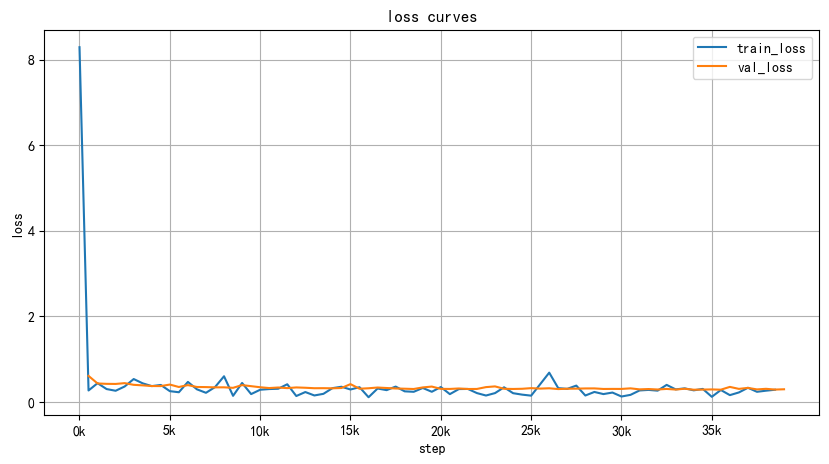

In [5]:
#画图
plot_learning_loss_curves(record_dict,sample_step=500)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_loss=evaluate_regression_model(model,test_loader,device,criterion)
print(f"测试集上的损失为{test_loss:.4f}")

测试集上的损失为0.2896
